In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.integrate as integrate
from sklearn.isotonic import IsotonicRegression
from datetime import datetime

## Model Parameters and Quality Sampling

In [20]:
class ThresholdConfParams:
    def __init__(self, n, mu_q, sig_q, sig_r):
        self.n = n            # number of papers
        self.mu_q = mu_q      # mean of quality prior
        self.sig_q = sig_q    # std of quality prior
        self.sig_r = sig_r    # std of review noise
        
        
# draw samples from quality distribution
def sample_q(para, nmc):
    samples = np.random.normal(loc=para.mu_q, scale=para.sig_q, size=(nmc,para.n))
    return np.sort(samples, axis = 1, kind='quicksort')[:,::-1]

## Threshold Sequential Mechanism

In [21]:
def sequential_quality(para, q, t_acc, t_rev):
    """
    The function takes input of:
        1. the parameter setting "para";
        2. a set of papers of size nmc*n, where n is the number of papers the author has, and nmc is the number of sample. Each row is ordered based on the quality of paper from high to low;
        3. the acceptance threhsold "t_acc";
        4. the reviewing threhsold "t_rev".
    The function outputs the average and the variance of the conference utility on q.
    """
    nmc = np.size(q, axis = 0)
    n = para.n
    sig_r = para.sig_r
    
    q_acc = np.zeros(nmc)
    q_rev = np.zeros(nmc)
    n_rev = np.zeros(nmc)
    for i in range(n):
        p_acc = 1-norm.cdf(t_acc-q[:,i],0,sig_r)
        p_rev = 1-norm.cdf(t_rev-q[:,:i],0,sig_r)
        q_acc += p_acc*np.prod(p_rev, axis = 1)*q[:,i]
        q_rev += np.prod(p_rev, axis = 1)*q[:,i]
        n_rev += np.prod(p_rev, axis = 1)
    return (np.average(q_acc), np.var(q_acc))

def sequential_quality_burden(para, q, t_acc, t_rev):
    """
    The funcion outputs the conference utiltiy, average quality of reviewed papers, and the review burden. See definitions of terms in section 5.
    """
    nmc = np.size(q, axis = 0)
    n = para.n
    sig_r = para.sig_r
    
    q_acc = np.zeros(nmc)
    q_rev = np.zeros(nmc)
    n_rev = np.zeros(nmc)
    for i in range(n):
        p_acc = 1-norm.cdf(t_acc-q[:,i],0,sig_r)
        p_rev = 1-norm.cdf(t_rev-q[:,:i],0,sig_r)
        q_acc += p_acc*np.prod(p_rev, axis = 1)*q[:,i]
        q_rev += np.prod(p_rev, axis = 1)*q[:,i]
        n_rev += np.prod(p_rev, axis = 1)
    return np.array((np.average(q_acc), np.average(q_rev/n_rev), np.average(n_rev)))

def sequential_quality_gradient(para, q, t_acc, t_rev):
    """
    This function ouputs the gradients of the conference utility w.r.t. the accetpance threshold and the reviewing threshold.
    """
    nmc = np.size(q, axis = 0)
    n = para.n
    sig_r = para.sig_r
    
    dt_acc = 0
    dt_rev = 0
    for i in range(n):
        p_acc = 1-norm.cdf(t_acc-q[:,i],0,sig_r)
        p_rev = 1-norm.cdf(t_rev-q[:,:i],0,sig_r)
        dp_acc = -norm.pdf(t_acc-q[:,i],0,sig_r)
        dp_rev = np.zeros(nmc)
        for j in range(i):
            dp_rev += np.prod(p_rev[:,:j], axis = 1)*np.prod(p_rev[:,(j+1):], axis = 1)*(-norm.pdf(t_rev-q[:,j],0,sig_r))
        dt_acc += dp_acc*np.prod(p_rev, axis = 1)*q[:,i]
        dt_rev += p_acc*q[:,i]*dp_rev
        
    return (np.average(dt_acc), np.average(dt_rev))

def SGD_sequential_threshold(para, mini_batch, alpha_acc, alpha_rev, num_itr):
    """
    This function takes inputs of:
        1. the parameter setting "para";
        2. the size of the samples "mini_batch" used to estimate the gradient in each iterationl;
        3. the step size of the acceptance threshold "alpha_acc";
        4. the step size of the reviewing threshold "alpha_rev";
        5. the number of iterations "num_itr".
    The function outputs the optimal accetpance threshold and the optimal reviewing threshold respectively.
    """
    global record_Q_sequential
    record_Q_sequential = []
    # initialization
    t_acc = 0
    t_rev = -0.5
    
    # update gradient
    for itr in range(num_itr):
        alpha_acc_i = alpha_acc/np.sqrt(itr+1)
        alpha_rev_i = alpha_rev/np.sqrt(itr+1)
        samples = sample_q(para, mini_batch)
        t_acc += sequential_quality_gradient(para, samples, t_acc, t_rev)[0]*alpha_acc_i
        t_rev += sequential_quality_gradient(para, samples, t_acc, t_rev)[1]*alpha_rev_i
        if t_acc < t_rev:
            t_rev = t_acc
        samples = sample_q(para, 10000)
        record_Q_sequential.append(sequential_quality(para, samples, t_acc, t_rev))
    return (t_acc, t_rev)

## Parallel Mechanism

In [22]:
"""
This section contains the analogous functions for the threhsold parallel mechanism.
"""

def parallel_quality(para, q, t_acc):
    nmc = np.size(q, axis = 0)
    n = para.n
    sig_r = para.sig_r
    
    q_acc = np.zeros(nmc)
    for i in range(n):
        p_acc = 1-norm.cdf(t_acc-q[:,i],0,sig_r)
        q_acc += p_acc*q[:,i]
    return (np.average(q_acc), np.var(q_acc))

def parallel_quality_gradient(para, q, t_acc):
    nmc = np.size(q, axis = 0)
    n = para.n
    sig_r = para.sig_r
    
    dt_acc = 0
    for i in range(n):
        dt_acc += -norm.pdf(t_acc-q[:,i],0,sig_r)*q[:,i]
        
    return np.average(dt_acc)

def SGD_parallel_threshold(para, mini_batch, alpha_acc, num_itr):
    global record_Q_parallel
    record_Q_parallel = []
    # initialization
    t_acc = 0
    
    # update gradient
    for itr in range(num_itr):
        alpha_acc_i = alpha_acc/np.sqrt(itr+1)
        samples = sample_q(para, mini_batch)
        t_acc += parallel_quality_gradient(para, samples, t_acc)*alpha_acc_i
        
        samples = sample_q(para, 10000)
        record_Q_parallel.append(parallel_quality(para, samples, t_acc))
    return t_acc

## Isotonic Mechanism

In [23]:
def isotonic_quality(para, q, t_acc):
    """
    This function is used to compute the conference utility under the isotonic mechanim.
    """
    nmc = np.size(q, axis = 0)
    n = para.n
    sig_r = para.sig_r
    
    q_acc = np.zeros(nmc)
    for i in range(nmc):
        for j in range(100):
            rn = np.random.normal(0, sig_r, n)
            score = q[i] + rn
            x = np.arange(n,0,-1)
            new_score = IsotonicRegression().fit_transform(x, score)
            q_acc[i] += np.sum(q[i][new_score > t_acc])/100
    
    return np.average(q_acc)

## Sampling

In [ ]:
"""
Optimize the thresholds for three mechanisms under different parameter settings
This takes hours to run, can skip (given stored data)
"""

n = 2
mu_list = [-1,0,1,2]
sig_q = 2
sig_list = [1]
threshold_list = np.arange(0,0.51,0.01)

Acc_q_iso = np.zeros(len(threshold_list))

for mu_q in mu_list:
    if mu_q == -2:
        threshold_list = np.arange(0,0.51,0.01)
    if mu_q == -1:
        threshold_list = np.arange(-0.1,0.41,0.01)
    if mu_q == 0:
        threshold_list = np.arange(-0.2,0.31,0.01)
    if mu_q == 1:
        threshold_list = np.arange(-0.3,0.21,0.01)
    for sig_r in sig_list:
        print('review noise = ', sig_r)
        para = ThresholdConfParams(
            n = n,
            mu_q = mu_q,
            sig_q = sig_q,
            sig_r = sig_r
            )
        samples = sample_q(para, 10000)
        t_acc_p = SGD_parallel_threshold(para, mini_batch=10000, alpha_acc = 0.4, num_itr=500)
        Acc_q_pal = np.array(parallel_quality(para, samples, t_acc_p)[0])
        
        t_acc_s, t_rev_s = SGD_sequential_threshold(para, mini_batch=10000, alpha_acc = 0.1, alpha_rev = 0.5, num_itr=500)
        Acc_q_seq = np.array(sequential_quality(para, samples, t_acc_s, t_rev_s)[0])
        
        for j,t in enumerate(threshold_list):
            if j%10 == 0:
                print(t, ',', datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
            Acc_q_iso[j] = isotonic_quality(para, samples, t)

        np.save('Numerical_results/n_'+str(n)+'_muq_'+str(mu_q)+'_stdq_'+str(sig_q)+'_stdr_'+str(sig_r)+'_parallel.npy', Acc_q_pal)
        np.save('Numerical_results/n_'+str(n)+'_muq_'+str(mu_q)+'_stdq_'+str(sig_q)+'_stdr_'+str(sig_r)+'_sequential.npy', Acc_q_seq)
        np.save('Numerical_results/n_'+str(n)+'_muq_'+str(mu_q)+'_stdq_'+str(sig_q)+'_stdr_'+str(sig_r)+'_isotonic.npy', Acc_q_iso)

In [ ]:
"""
Estimate variance. Take about 5 minutes to run
"""

n_list = [2,3,4,5,10,20]
mu_list = [-1,0,1]
sig_q = 2
sig_r = 1

var_pal = np.zeros((3,6))
var_seq = np.zeros((3,6))
t_pal = np.zeros((3,6))
t_seq = np.zeros((3,6,2))

for i,mu_q in enumerate(mu_list):
    for j,n in enumerate(n_list):
        para = ThresholdConfParams(
            n = n,
            mu_q = mu_q,
            sig_q = sig_q,
            sig_r = sig_r
            )
        samples = sample_q(para, 100000)
        t_acc_p = SGD_parallel_threshold(para, mini_batch=10000, alpha_acc = 0.4, num_itr=500)
        t_pal[i,j] = t_acc_p
        _,var_pal[i,j] = parallel_quality(para, samples, t_pal[i,j])
        
        t_acc_s, t_rev_s = SGD_sequential_threshold(para, mini_batch=10000, alpha_acc = 0.1, alpha_rev = 0.5, num_itr=500)
        t_seq[i,j] = np.array([t_acc_s, t_rev_s])
        _,var_seq[i,j] = Acc_q_seq = sequential_quality(para, samples, t_seq[i,j,0], t_seq[i,j,1])
        

Text(0, 0.5, 'Relative conference utility')

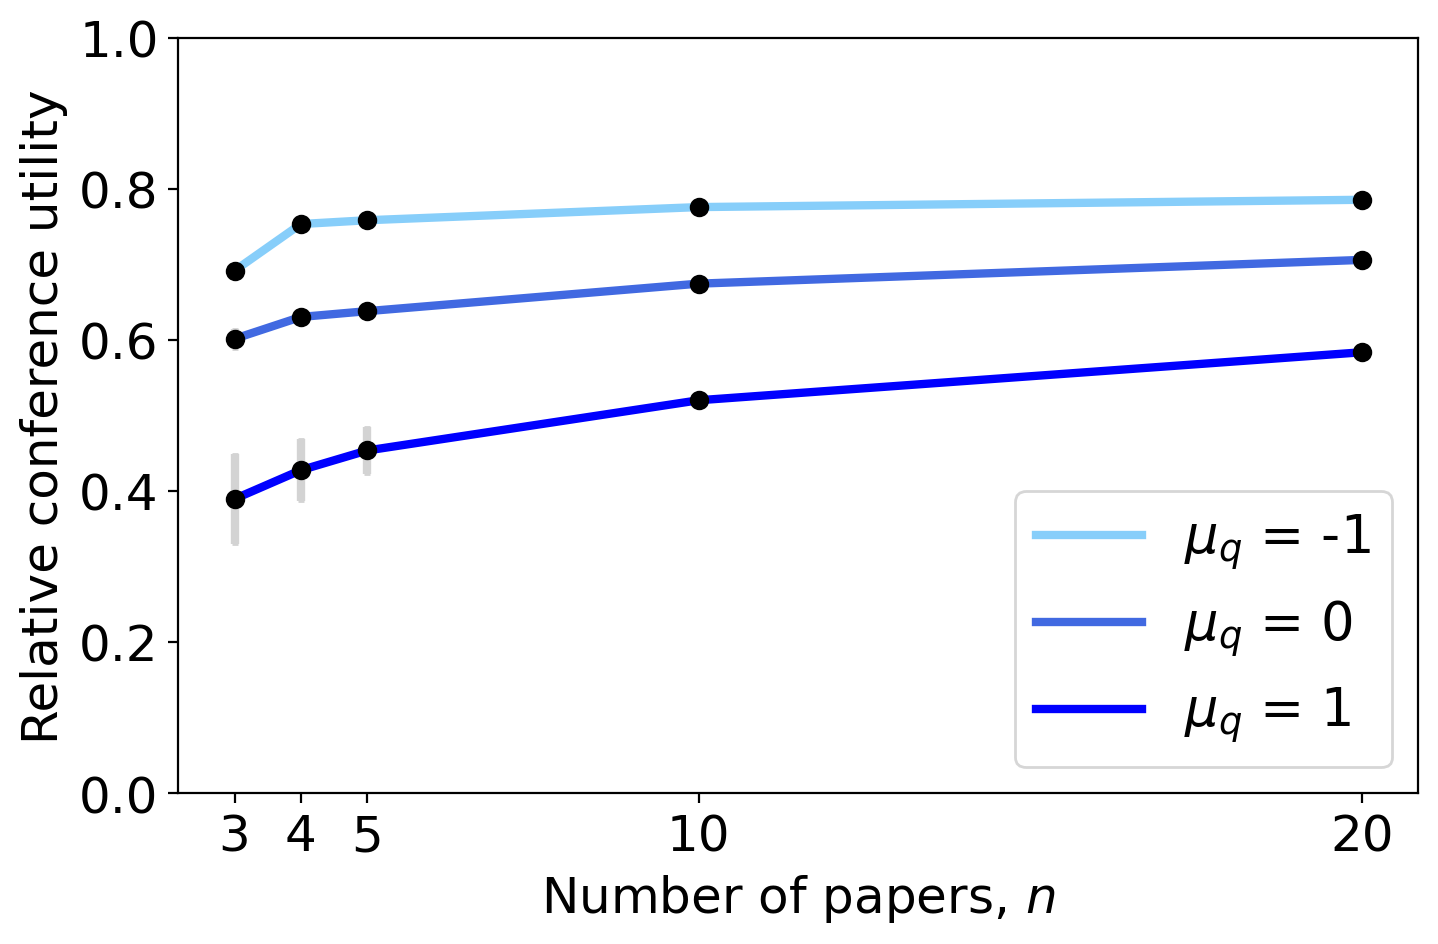

In [28]:
"""
Varying n
"""

n_list = [3,4,5,10,20]
mu_list = [-1,0,1]
sig_q = 2
sig_r = 1

color_list = ['lightskyblue', 'royalblue', 'blue']

x = n_list
plt.figure(figsize=(8,5), dpi= 200)
for i,mu_q in enumerate(mu_list):
    y = np.zeros(len(n_list))
    dy = np.zeros(len(n_list))
    for j,n in enumerate(n_list):
        Acc_q_pal = np.load('Numerical_results/n_'+str(n)+'_muq_'+str(mu_q)+'_stdq_'+str(sig_q)+'_stdr_'+str(sig_r)+'_parallel.npy')
        Acc_q_seq = np.load('Numerical_results/n_'+str(n)+'_muq_'+str(mu_q)+'_stdq_'+str(sig_q)+'_stdr_'+str(sig_r)+'_sequential.npy')
        Acc_q_iso = np.load('Numerical_results/n_'+str(n)+'_muq_'+str(mu_q)+'_stdq_'+str(sig_q)+'_stdr_'+str(sig_r)+'_isotonic.npy')
        
        y[j] = (Acc_q_seq - Acc_q_pal)/(np.max(Acc_q_iso) - Acc_q_pal)
        dy[j] = (np.square(var_pal[i,j]) + np.square(var_seq[i,j]))/np.square(np.max(Acc_q_iso) - Acc_q_pal)/100000
        
    plt.plot(x,y, color = color_list[i], linewidth = 3, label = r'$\mu_q$ = '+str(mu_q))
    plt.errorbar(x, y, yerr=dy, fmt='o', color='black',
                 ecolor='lightgray', elinewidth=3, capsize=1)
    
plt.ylim(0,1)
plt.legend(fontsize = 19)
plt.tick_params(labelsize=18)
plt.xticks(n_list)
plt.xlabel(r'Number of papers, $n$', fontsize = 18)
plt.ylabel('Relative conference utility', fontsize = 18)

Text(0, 0.5, 'Relative conference utility')

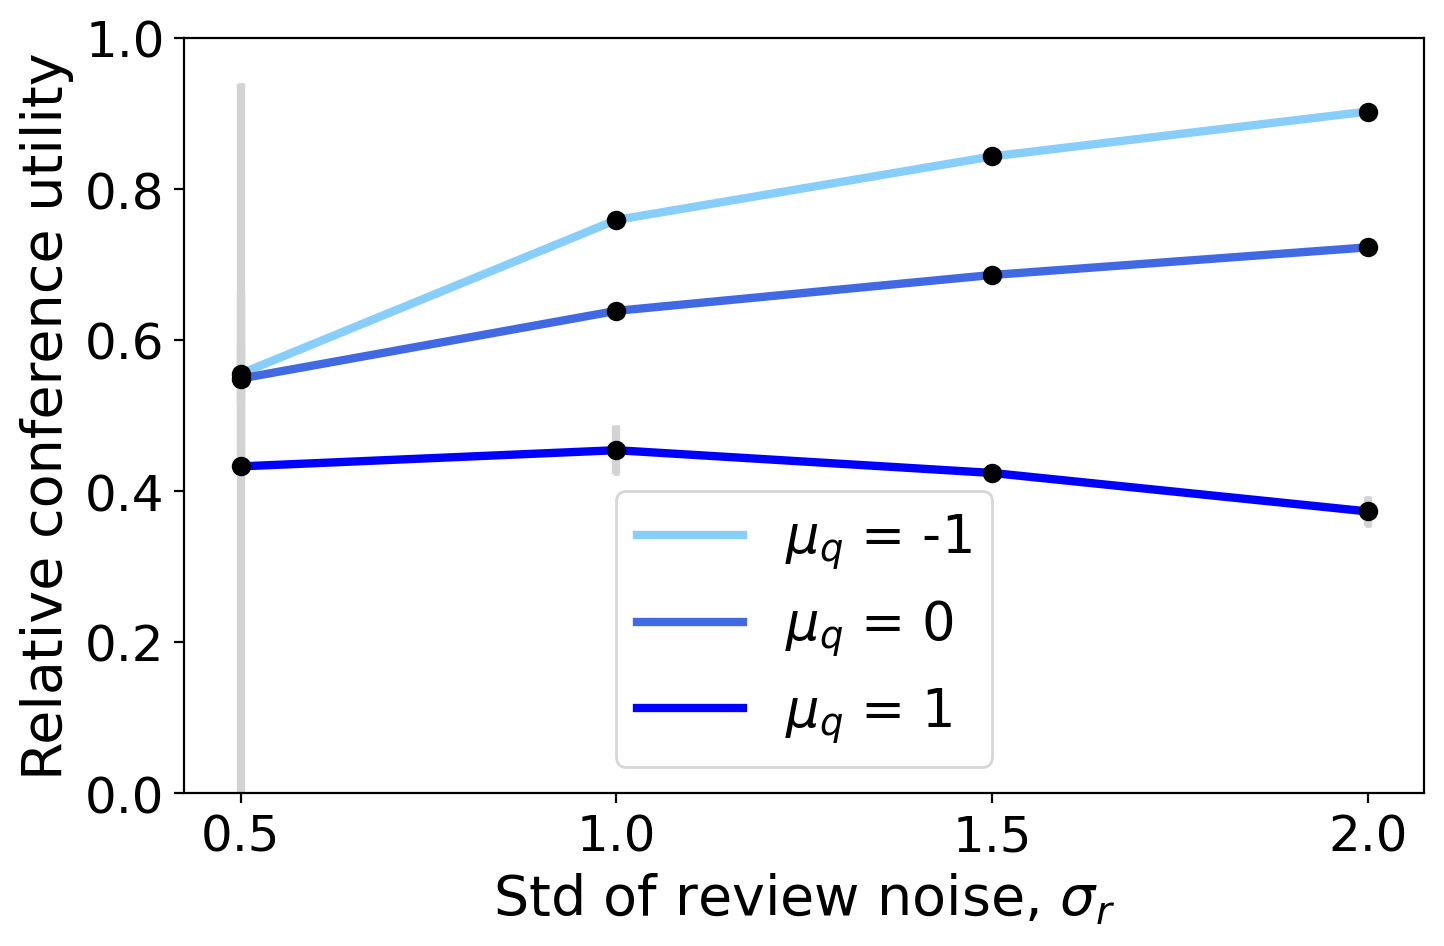

In [19]:
"""
Varying sigma_r
"""

n = 5
mu_list = [-1,0,1]
sig_q = 2
sig_list = [ 0.5, 1, 1.5, 2]
threshold_list = np.arange(0,0.51,0.01)

color_list = ['lightskyblue', 'royalblue', 'blue']

x = sig_list
plt.figure(figsize=(8,5), dpi= 200)
for i,mu_q in enumerate(mu_list):
    y = np.zeros(len(sig_list))
    dy = np.zeros(len(sig_list))
    for j,sig_r in enumerate(sig_list):
        Acc_q_pal = np.load('Numerical_results/n_'+str(n)+'_muq_'+str(mu_q)+'_stdq_'+str(sig_q)+'_stdr_'+str(sig_r)+'_parallel.npy')
        Acc_q_seq = np.load('Numerical_results/n_'+str(n)+'_muq_'+str(mu_q)+'_stdq_'+str(sig_q)+'_stdr_'+str(sig_r)+'_sequential.npy')
        Acc_q_iso = np.load('Numerical_results/n_'+str(n)+'_muq_'+str(mu_q)+'_stdq_'+str(sig_q)+'_stdr_'+str(sig_r)+'_isotonic.npy')
        
        y[j] = (Acc_q_seq - Acc_q_pal)/(np.max(Acc_q_iso) - Acc_q_pal)
        dy[j] = (np.square(var_pal[i,j+1]) + np.square(var_seq[i,j+1]))/np.square(np.max(Acc_q_iso) - Acc_q_pal)/400000
        
    plt.plot(x,y, color = color_list[i], linewidth = 3, label = r'$\mu_q$ = '+str(mu_q))
    plt.errorbar(x, y, yerr=dy, fmt='o', color='black',
                 ecolor='lightgray', elinewidth=3, capsize=1)
    
plt.ylim(0,1)
plt.legend(fontsize = 19)
plt.tick_params(labelsize=18)
plt.xticks(sig_list)
plt.xlabel(r'Std of review noise, $\sigma_r$', fontsize = 20)
plt.ylabel('Relative conference utility', fontsize = 20)
        

## Review burden

In [259]:
## Find the minimum review burden (maximum average quality of reviewed papers) of the sequential mechanism conditioned on the same conference utility

def find_t_max(x, y, z):
    """
    x: review burden of the sequantial mechanism (array)
    y: conference utility of the sequential mechanism (array)
    z: conference utility of the parallel mechanism (value)
    """
    # Fit a quadratic function to the data
    coefficients = np.polyfit(x, y, 2)
    a, b, c = coefficients
    
    # Solve the quadratic equation ax^2 + bx + c = z
    discriminant = b**2 - 4*a*(c - z)
    if discriminant <= 0:
        t = -b / (2*a)
        return t
    else:
        # Two solutions
        t1 = (-b + np.sqrt(discriminant)) / (2*a)
        t2 = (-b - np.sqrt(discriminant)) / (2*a)
        return max(t1, t2)

def find_t_min(x, y, z):
    """
    x: review burden of the sequantial mechanism (array)
    y: conference utility of the sequential mechanism (array)
    z: conference utility of the parallel mechanism (value)
    """
    # Fit a quadratic function to the data
    coefficients = np.polyfit(x, y, 2)
    a, b, c = coefficients
    
    # Solve the quadratic equation ax^2 + bx + c = z
    discriminant = b**2 - 4*a*(c - z)
    if discriminant <= 0:
        t = -b / (2*a)
        return t
    else:
        # Two solutions
        t1 = (-b + np.sqrt(discriminant)) / (2*a)
        t2 = (-b - np.sqrt(discriminant)) / (2*a)
        return min(t1, t2)

In [ ]:
"""
Varying n
"""
n_list = range(2,11)
mu_list = [-1,0,1]
sig_q = 3
sig_r = 1
t_acc_list = np.arange(-1.5,1,0.1)

Acc_q_seq = np.zeros((len(mu_list), len(n_list), len(t_acc_list)))
Rev_q_seq = np.zeros((len(mu_list), len(n_list), len(t_acc_list)))
Rev_n_seq = np.zeros((len(mu_list), len(n_list), len(t_acc_list)))
Acc_q_pal = np.zeros((len(mu_list), len(n_list), len(t_acc_list)))

for i,mu_q in enumerate(mu_list):
    for j,n in enumerate(n_list):
        para = ThresholdConfParams(
                n = n,
                mu_q = mu_q,
                sig_q = sig_q,
                sig_r = sig_r
                )

        for k,t in enumerate(t_acc_list):
            samples = sample_q(para, 100000)
            Acc_q_seq[i,j,k], Rev_q_seq[i,j,k], Rev_n_seq[i,j,k] = sequential_quality_burden(para, samples, t, t)
            Acc_q_pal[i,j,k] = parallel_quality(para, samples, t)

(0.0, 1.0)

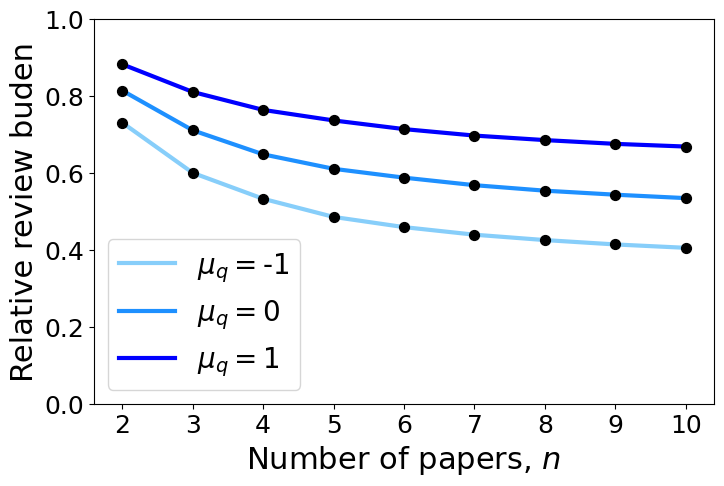

In [201]:
import numpy as np
color_list = ['lightskyblue' ,'dodgerblue', 'blue', 'navy']
mu_list = [-1,0,1]

x = n_list
plt.figure(figsize=(8,5))
for i,mu_q in enumerate(mu_list):
    y = np.zeros(len(n_list))
    for j,n in enumerate(n_list):
        y[j] = find_t_min(Rev_n_seq[i,j], Acc_q_seq[i,j], np.max(Acc_q_pal[i,j]))
    plt.plot(x,(y/np.array(x)), linewidth = 3, color = color_list[i], label = r'$\mu_q=$'+str(mu_q), zorder=0)
    plt.scatter(x,(y/np.array(x)), s = 50, color = 'black')
        
plt.xlabel(r'Number of papers, $n$', fontsize = '22')
plt.ylabel(r'Relative review buden', fontsize = '22')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize = 20)
plt.ylim(0,1)


(-2.0, 2.6)

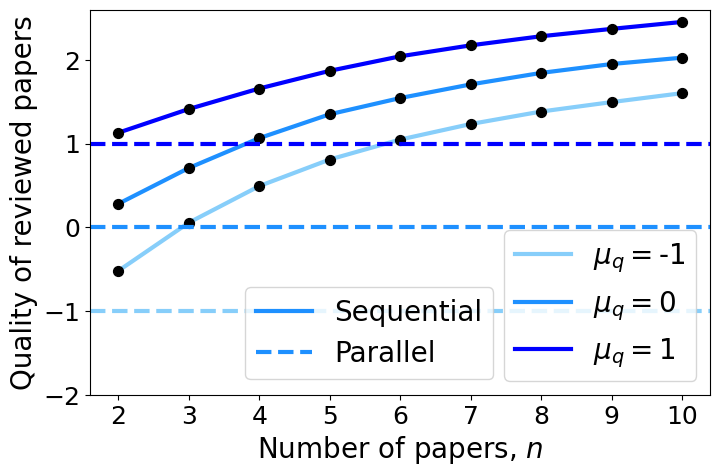

In [228]:
import numpy as np
color_list = ['lightskyblue' ,'dodgerblue', 'blue', 'navy']
mu_list = [-1,0,1]

x = n_list
plt.figure(figsize=(8,5))
for i,mu_q in enumerate(mu_list):
    y = np.zeros(len(n_list))
    for j,n in enumerate(n_list):
        y[j] = find_t_max(Rev_q_seq[i,j], Acc_q_seq[i,j], np.max(Acc_q_pal[i,j]))
    
    if i == 1:
        seq, = plt.plot(x,(y), linewidth = 3, color = color_list[i], label = r'$\mu_q=$'+str(mu_q), zorder=0)
        pal = plt.axhline(y=mu_q, linewidth = 3, linestyle = '--', color = color_list[i],)
        plt.scatter(x,(y), s = 50, color = 'black')
    else:
        plt.scatter(x,(y), s = 50, color = 'black')
        plt.plot(x,(y), linewidth = 3, color = color_list[i], label = r'$\mu_q=$'+str(mu_q), zorder=0)
        plt.axhline(y=mu_q, linewidth = 3, linestyle = '--', color = color_list[i],)
        
plt.xlabel(r'Number of papers, $n$', fontsize = '20')
plt.ylabel(r'Quality of reviewed papers', fontsize = '20')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
legend2 = plt.legend([seq, pal], ['Sequential', 'Parallel'], fontsize = '20', loc = (0.25, 0.04))
plt.legend(fontsize = 20)
plt.gca().add_artist(legend2)
plt.ylim(-2,2.6)


In [256]:
"""
Varying sig_r (review noise)
"""
n = 5
mu_list = [-2,-1,0,1]
sig_q = 3
sig_list = [0.5, 1, 1.5, 2]
t_acc_list = np.arange(-1.5,1.5,0.1)

Acc_q_seq = np.zeros((len(mu_list), len(sig_list), len(t_acc_list)))
Rev_q_seq = np.zeros((len(mu_list), len(sig_list), len(t_acc_list)))
Rev_n_seq = np.zeros((len(mu_list), len(sig_list), len(t_acc_list)))
Acc_q_pal = np.zeros((len(mu_list), len(sig_list), len(t_acc_list)))

for i,mu_q in enumerate(mu_list):
    for j,sig_r in enumerate(sig_list):
        para = ThresholdConfParams(
                n = n,
                mu_q = mu_q,
                sig_q = sig_q,
                sig_r = sig_r
                )

        for k,t in enumerate(t_acc_list):
            samples = sample_q(para, 100000)
            Acc_q_seq[i,j,k], Rev_q_seq[i,j,k], Rev_n_seq[i,j,k] = sequential_quality_burden(para, samples, t, t)
            Acc_q_pal[i,j,k] = parallel_quality(para, samples, t)

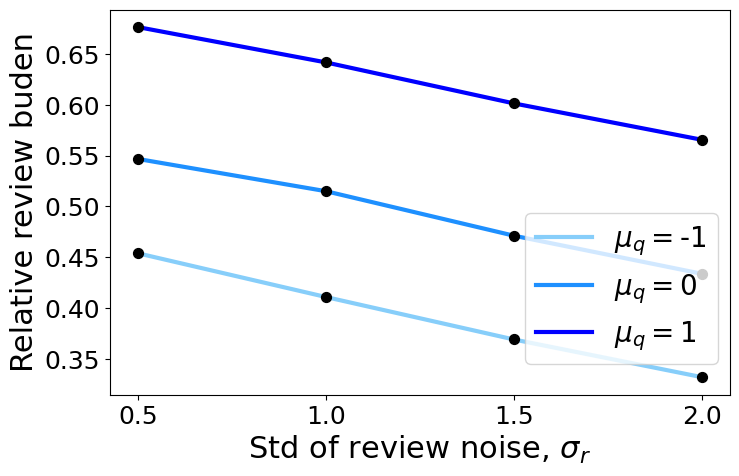

In [260]:
import numpy as np
color_list = ['lightskyblue' ,'dodgerblue', 'blue', 'navy']
mu_list = [-1,0,1]

sig_list = [0.5,1,1.5,2]
x = sig_list
plt.figure(figsize=(8,5))
for i,mu_q in enumerate(mu_list):
    y = np.zeros(len(sig_list))
    for j,sig_r in enumerate(sig_list):
        y[j] = find_t_min(Rev_n_seq[i,j], Acc_q_seq[i,j], np.max(Acc_q_pal[i,j]))

    plt.scatter(x,(y)/5, s = 50, color = 'black')
    plt.plot(x,(y)/5, linewidth = 3, color = color_list[i], label = r'$\mu_q=$'+str(mu_q), zorder=0)
        
plt.xlabel(r'Std of review noise, $\sigma_r$', fontsize = '22')
plt.ylabel(r'Relative review buden', fontsize = '22')
plt.xticks(sig_list, fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize = 20, loc = (0.67,0.08))
# plt.ylim(-1.2,1.7)


(-1.2, 1.7)

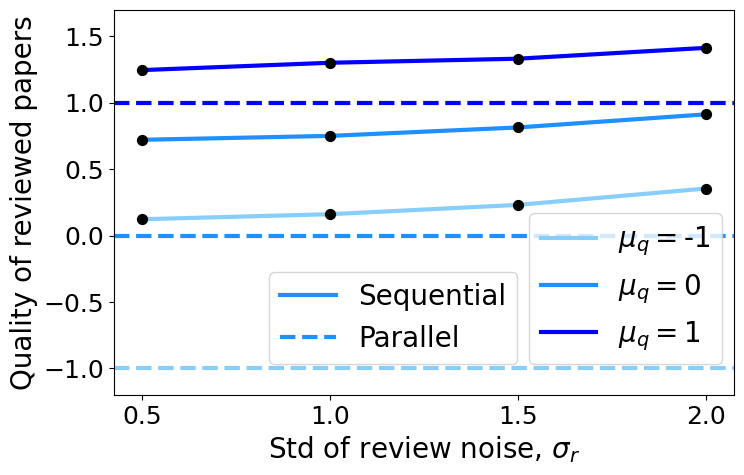

In [251]:
import numpy as np
color_list = ['lightskyblue' ,'dodgerblue', 'blue', 'navy']
mu_list = [-1,0,1]

sig_list = [0.5,1,1.5,2]
x = sig_list
plt.figure(figsize=(8,5))
for i,mu_q in enumerate(mu_list):
    y = np.zeros(len(sig_list))
    for j,sig_r in enumerate(sig_list):
        y[j] = find_t_max(Rev_q_seq[i,j], Acc_q_seq[i,j], np.max(Acc_q_pal[i,j]))
    
    if i == 1:
        seq, = plt.plot(x,(y), linewidth = 3, color = color_list[i], label = r'$\mu_q=$'+str(mu_q), zorder=0)
        pal = plt.axhline(y=mu_q, linewidth = 3, linestyle = '--', color = color_list[i],)
        plt.scatter(x,(y), s = 50, color = 'black')
    else:
        plt.scatter(x,(y), s = 50, color = 'black')
        plt.plot(x,(y), linewidth = 3, color = color_list[i], label = r'$\mu_q=$'+str(mu_q), zorder=0)
        plt.axhline(y=mu_q, linewidth = 3, linestyle = '--', color = color_list[i],)
        
plt.xlabel(r'Std of review noise, $\sigma_r$', fontsize = '20')
plt.ylabel(r'Quality of reviewed papers', fontsize = '20')
plt.xticks(sig_list, fontsize=18)
plt.yticks(fontsize=18)
legend2 = plt.legend([seq, pal], ['Sequential', 'Parallel'], fontsize = '20', loc = (0.25, 0.08))
plt.legend(fontsize = 20, loc = (0.67,0.08))
plt.gca().add_artist(legend2)
plt.ylim(-1.2,1.7)


In [ ]:
import os
import time

import requests
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait


def download_all_papers(base_url, save_dir, driver_path):
    driver = webdriver.Chrome(driver_path)
    driver.get(base_url)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # wait for the select element to become visible
    WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.CLASS_NAME, "submissions-list")))
    pagination_elems = driver.find_element(By.CSS_SELECTOR, "ul[class='pagination']").find_elements_by_tag_name("li")
    max_pages = len(pagination_elems) - 4  # remove unnumbered navigation elements: <<, <, >, >>

    i = 1
    while True:
        print("Successfully loaded the page " + str(i))

        # parse the results
        divs = driver.find_elements_by_class_name('note')
        num_papers = len(divs)
        print(num_papers)

        for index, paper in enumerate(divs):
            anchors = paper.find_elements_by_tag_name("a")
            name = anchors[0].text
            name = name.replace(":", " -").replace("?", "").replace("\"", "").replace("\'", "").replace("*", "")
            link = anchors[1].get_attribute('href')
            print('Downloading paper {}/{}: {}'.format(index+1, num_papers, name))
            download_pdf(link, os.path.join(save_dir, name))

        # switch to next page and increment i
        if i == max_pages:
            break
        i += 1

        dataPageNumberString = "[data-page-number='" + str(i) + "']"
        click_elem_li = driver.find_element(By.CSS_SELECTOR, "li[class='  right-arrow']" + dataPageNumberString)
        click_elem_li.find_elements_by_tag_name("a")[0].click()

        WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.CLASS_NAME, "submissions-list")))
        time.sleep(10)

    driver.close()


if __name__ == '__main__':
    NIPS = 'https://openreview.net/group?id=NeurIPS.cc/2022/Track/Datasets_and_Benchmarks'
    driver_path = 'C:\\Users\\username\\path\\to\\chromedriver.exe'
    save_dir_nips = 'C:\\Users\\username\\path\\to\\save\\downloaded\\papers'

    download_all_papers(NIPS, save_dir_nips, driver_path)